<a href="https://colab.research.google.com/github/Jaesu26/dacon-3d-mnist-image-classification/blob/main/2022-09-01-%EC%88%AB%EC%9E%903D%EC%9D%B4%EB%AF%B8%EC%A7%80-%EB%B6%84%EB%A5%98-%EB%94%A5%EB%9F%AC%EB%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 숫자 3D 이미지 분류 AI 경진대회

## 데이터 불러오기

In [1]:
import numpy as np
import numpy.typing as npt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import h5py
import cv2
import os
import gc

from typing import Callable, Dict, Sequence, List, Optional, Tuple, Union
from tqdm.notebook import tqdm
from glob import glob

warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive

drive.mount('/content/drive') ## 구글코랩과 구글드라이브 연결

Mounted at /content/drive


In [3]:
%cd  '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data'

/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data


In [4]:
# !unzip -qq '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류/Data/open.zip'

In [5]:
%cd  '/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류'

/content/drive/MyDrive/Colab Notebooks/숫자3D이미지-분류


- 데이터 불러오기

In [6]:
label_df = pd.read_csv('./Data/train.csv')
# all_points = h5py.File('./Data/train.h5', 'r')

In [7]:
test_df = pd.read_csv('./Data/sample_submission.csv')
# test_points = h5py.File('./Data/test.h5', 'r')

In [8]:
target = label_df['label'].values

- 하이퍼파라미터

In [9]:
MODEL_NAME = 'efficientnet_b1'
MODEL_DEFAULT_WEIGHT_PATH = f'{MODEL_NAME}_default_weight.pt' 
SAVE_PATH = './weight'
NUM_CLASSES = 10
NUM_FOLDS = 5
NUM_EPOCHS = 100
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
LABEL_SMOOTHING = 0.05  ## 적절한 값을 설정하여 모델이 예측한 것을 과하게 확신하지 못하게 함
IMAGE_H = 112
IMAGE_W = 112
SEED = 2022

- 가중치 저장폴더

In [ ]:
def create_folder(path: str) -> None:
    try:
        if not os.path.exists(path):
            os.makedirs(path)
    except OSError as error:
        print(error)

In [ ]:
create_folder(SAVE_PATH)

## 시각화

- 라벨

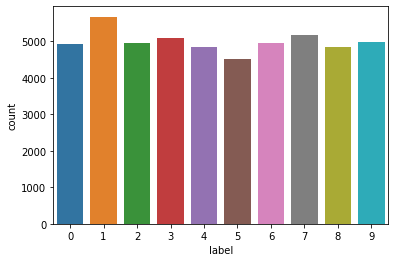

In [ ]:
sns.countplot(data=label_df, x='label')

`-` 라벨별 개수는 비슷하다

In [ ]:
def show_3Dimage(_3d_point_images, id: int, label_df=None):
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    
    _3d_point_image = _3d_point_images[str(id)][:]
    x = _3d_point_image[:, 0]
    y = _3d_point_image[:, 1]
    z = _3d_point_image[:, 2]
    ax.scatter(x, y, z, alpha=0.04)

    if label_df is not None:
        label = label_df.loc[label_df['ID'] == id, 'label'].item()
        ax.set_title(label, fontsize=16)
    plt.show()

- 3차원 이미지

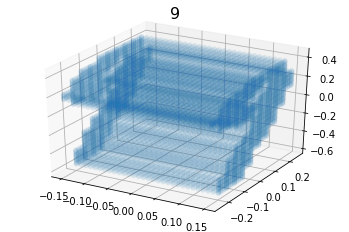

In [ ]:
show_3Dimage(all_points, 24983, label_df)

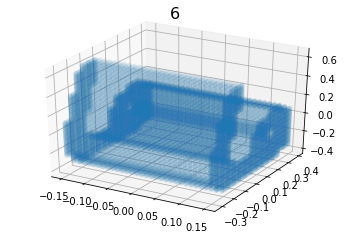

In [ ]:
show_3Dimage(all_points, 49977, label_df)

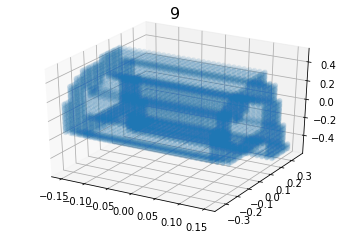

In [ ]:
show_3Dimage(all_points, 49983, label_df)

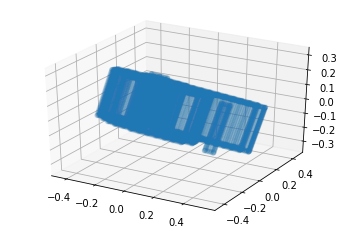

In [ ]:
show_3Dimage(test_points, 81110)

`-` train 이미지는 yz 평면에 숫자를 그린 후 x축으로 팽창되어 있다

`-` test 이미지는 그렇지 않기에(대략 1:1 비율) 적절한 변환이 필요하다  

`-` 6과 9는 뒤집어져 있으면 구분이 안되지만 위와 같이 옆으로 누워있는 3D 이미지도 존재한다

`-` 보통, 글자 6을 쓸 때 막대기부터 쓰고 9는 동그라미부터 쓴다

`-` 6의 경우 막대기가 강조되어 있으며 9의 경우 동그라미가 강조되어 있다 

`-` 2와 5도 뒤집어져 있으면 구분이 잘 안된다

`-` 나머지는 구분이 잘 된다

- 3차원 이미지 좌표의 분포 확인

- train

In [ ]:
count = 0
for i in tqdm(range(50000, 90000)):
    data = test_points[str(i)][:]
    xx = np.max(data[:, 0])
    if xx >= 0.16:
        count += 1

100%|██████████| 40000/40000 [04:07<00:00, 161.62it/s]


In [ ]:
count

19987

In [ ]:
x_data, y_data, z_data = [], [], []
for i in tqdm(range(50000)):
    data = all_points[str(i)][:]
    x_data.extend(list(set(data[:, 0])))
    y_data.extend(list(set(data[:, 1])))
    z_data.extend(list(set(data[:, 2])))

100%|██████████| 50000/50000 [09:55<00:00, 84.03it/s]


In [ ]:
len(x_data), len(y_data), len(z_data)

(19421718, 3182493, 8463666)

{'boxes': [<matplotlib.lines.Line2D at 0x7f52f4822710>],
 'caps': [<matplotlib.lines.Line2D at 0x7f52f482d750>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f52f4836750>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f52f4836250>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f52f4822c90>,
  <matplotlib.lines.Line2D at 0x7f52f482d210>]}

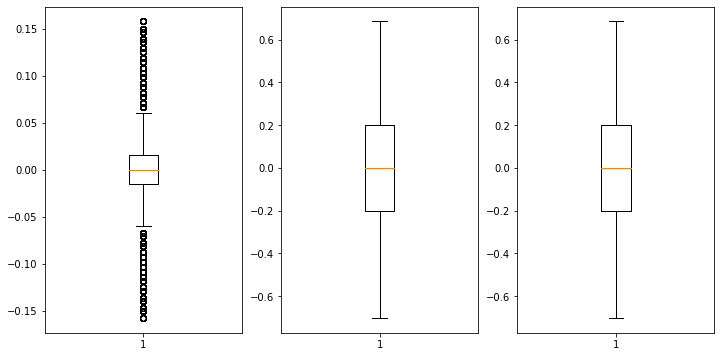

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.boxplot(x_data)
ax2.boxplot(y_data)
ax3.boxplot(y_data)

- test

In [ ]:
x_data, y_data, z_data = [], [], []
dot_counts = []
for i in tqdm(range(50000, 55000)):
    data = test_points[str(i)][:]
    dot_counts.append(data.shape[0])
    x_data.extend(list(set(data[:, 0])))
    y_data.extend(list(set(data[:, 1])))
    z_data.extend(list(set(data[:, 2])))

100%|██████████| 5000/5000 [01:30<00:00, 55.02it/s]


In [ ]:
len(x_data), len(y_data), len(z_data), max(dot_counts)

(42576466, 41770274, 42032192, 34750)

{'boxes': [<matplotlib.lines.Line2D at 0x7efc8f53ef50>],
 'caps': [<matplotlib.lines.Line2D at 0x7efc8f548d50>,
 'fliers': [<matplotlib.lines.Line2D at 0x7efc8f54fe50>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7efc8f54f910>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7efc8f548390>,
  <matplotlib.lines.Line2D at 0x7efc8f5488d0>]}

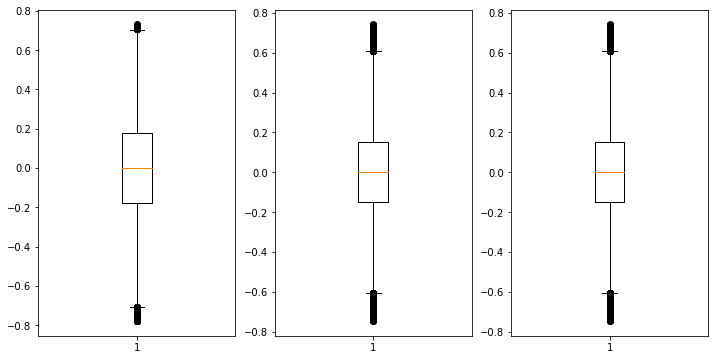

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))
ax1.boxplot(x_data)
ax2.boxplot(y_data)
ax3.boxplot(y_data)

`-` train과 비교했을 때 x축의 범위가 5배는 더 넓다

`-` train 데이터의 경우 x축의 범위가 -0.15~0.15 이다

`-` train 이미지는 yz 평면에 숫자를 그리고 x축으로 팽창시킨 반면에 test는 그렇지 않다

`-` RAM 용량 문제로 test data는 5000개만 사용함

## 데이터 전처리

`-` 위의 시각화를 보면 3차원이 아니라 2차원이더라도 숫자를 구분할 수 있을 듯하다

`-` 3차원 points를 2차원 이미지로 변경하자

`-` pretrained model도 사용할 수 있으며 파라미터도 더 적어진다

### 3D points $\to$ 2D points 

`-` 3D points는 축 하나의 범위가 -0.15 ~ 0.15인 경우와 그렇지 않은 경우로 나뉜다

`-` 전자의 경우 -0.15 ~ 0.15의 범위를 가지는 축으로 3차원 점들을 정사영시키면 된다 

`-` 후자의 경우 특이값 분해 또는 고유값 분해를 이용하여 2차원 점으로 만든다 (고유값 분해가 더 낫다)

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
def z_scale(points):
    col = points.shape[1]
    scaled_points = []

    for i in range(col):
        p = points[:, i]
        pp = (p - np.mean(p)) / np.std(p)
        scaled_points.append(pp)

    scaled_points = np.column_stack(tuple(scaled_points))
    return scaled_points

In [ ]:
def svd_3d_to_2d(_3d_points_array, scaling=False):
    """ SVD를 이용하여 3D 이미지를 2D 이미지로 축소"""
    X = _3d_points_array
    if scaling:
        X = z_scale(X)

    U, d, V = np.linalg.svd(X.T @ X)
    V_tilde = np.column_stack((-V[:, 1], -V[:, 0])) ## 각도 조절
    _2d_point_array = X @ V_tilde
    return _2d_point_array

In [ ]:
def eig_3d_to_2d(_3d_points_array, scaling=False):
    """ 고유값 분해를 이용하여 3D 이미지를 2D 이미지로 축소 """
    X = _3d_points_array
    if scaling:
        X = z_scale(X)

    Lambda, Psi = np.linalg.eig(X.T @ X)
    _1st, _2nd, _3rd = sorted(Lambda, key = lambda x: -x)  ## 내림차순 정렬
    idx_1st = np.array(list(np.where(Lambda == _1st))).item(0, 0)
    idx_2nd = np.array(list(np.where(Lambda == _2nd))).item(0, 0)
    
    Psi_tilde = np.column_stack((-Psi[:, idx_2nd], -Psi[:, idx_1st])) ## 각도 조절
    _2d_point_array = X @ Psi_tilde
    return _2d_point_array

In [ ]:
def show_2Dimages(_3d_points_images, id, scaling=False):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 6))
    pca = PCA(n_components=2)

    X = _3d_points_images[str(id)][:]
    svd_z = svd_3d_to_2d(X, scaling)
    eig_z = eig_3d_to_2d(X, scaling)
    pca_z = pca.fit_transform(X)

    ax1.plot(svd_z[:,0], svd_z[:,1], '.', alpha=0.5)
    ax2.plot(eig_z[:,0], eig_z[:,1], '.', alpha=0.5)
    ax3.plot(pca_z[:,0], pca_z[:,1], '.', alpha=0.5)

    ax1.set_title('SVD')
    ax2.set_title('Eigen')
    ax3.set_title('PCA')
    plt.show()    

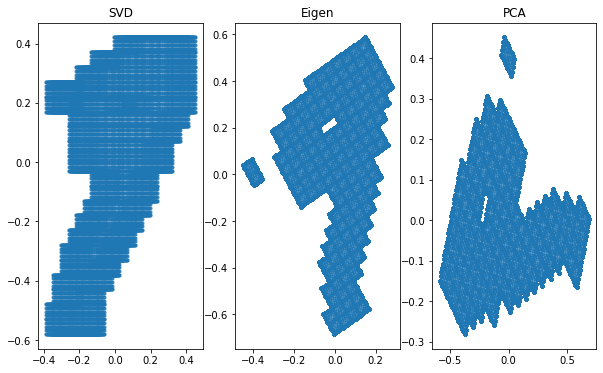

In [ ]:
show_2Dimages(all_points, 41483)

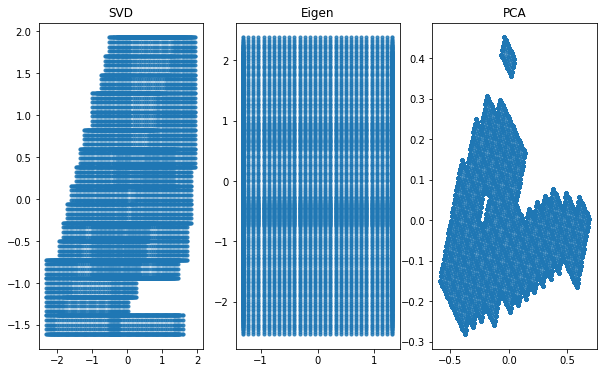

In [ ]:
show_2Dimages(all_points, 41483, scaling=True)

`-` SVD와 고유값 분해는 output의 차이가 존재한다 (무엇이 어떻게 다른지 까먹어서 공부해야...)

`-` 고유값 분해가 SVD 보다 원본 이미지를 잘 보존하는 듯하다

`-` PCA는 고유값 분해와 output이 동일하다 (각도만 다르다)

`-` 식별 가능한 이미지를 생성하기엔 스케일링을 하지 않는 것이 더 낫다

`-` 스케일링을 하면 팽창된 부분 (-0.15 ~ 0.15)의 range가 다른 axis의 range와 비슷해져 원본 이미지를 보존하지 못한다 (스케일링 한 것과 안 한것을 비교하면 바로 알 수 있음)

`-` [$\star$] 위 코드의 목적은 데이터 분산을 보존하는 것이 아니라 `식별 가능한 이미지`를 `보존`하는 것이다 [$\star$]

- just 정사영

In [ ]:
def project_point2plane(_3d_points_array):
    """
    xy or yz or zx 평면에 숫자를 그리고(draw) 나머지 하나의 축으로 팽창시킨 경우 (축의 범위: -0.15 ~ 0.15)  
    """
    x = _3d_points_array[:, 0]
    y = _3d_points_array[:, 1]
    z = _3d_points_array[:, 2]

    x_range = np.max(x) - np.min(x)
    y_range = np.max(y) - np.min(y)
    z_range = np.max(z) - np.min(z)

    if 0.28 < x_range < 0.32:  ## 범위가 대략 -0.15 ~ 0.15 이니까 range는 대략 0.28 ~ 0.32 일 것이다
        new_x = _3d_points_array[:, 1]
        new_y = _3d_points_array[:, 2]
    elif 0.28 < y_range < 0.32:
        new_x = _3d_points_array[:, 0]
        new_y = _3d_points_array[:, 2]
    elif 0.28 < z_range < 0.32:
        new_x = _3d_points_array[:, 0]
        new_y = _3d_points_array[:, 1]
    else:
        return None

    _2d_point_array = np.column_stack((new_x, new_y))
    return _2d_point_array

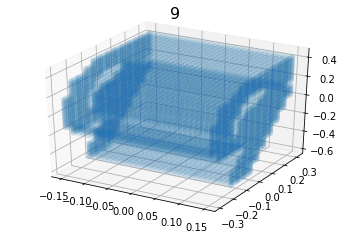

In [ ]:
show_3Dimage(all_points, 3483, label_df)

In [ ]:
z = project_point2plane(all_points['3483'][:])

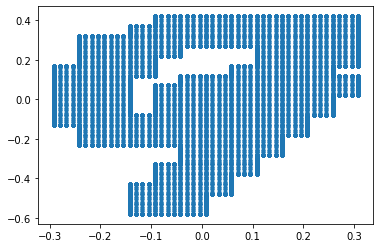

In [ ]:
plt.plot(z[:, 0], z[:, 1], '.')

### 2D points $\to$ 2D image

`-` size $\times$ size 크기의 격자를 만들고 격자 내부의 해당하는 점의 개수를 픽셀값으로 하여 2D 이미지를 만들겠다

`-` 최댓값을 기준으로 하는 것은 너무 위험한 것 같다 (이상치에 매우 민감함)

`-` 점이라도 엉뚱한데 하나 찍혀있으면 이미지가 왜곡된다

`-` 최댓값 대신 0.1% 사분위수와 같이 이상치에 덜 민감한 값을 사용하자

In [ ]:
def points2image(points, x_y=[28, 28]):
    ## (xmax, ymax), (xmax, ymin), (xmin, ymax), (xmin, ymin)을 네 점으로 하는 사각형 생성
    delta = 0.1
    xmax = np.max(points[:, 0]) + delta
    xmin = np.min(points[:, 0]) - delta
    ymax = np.max(points[:, 1]) + delta
    ymin = np.min(points[:, 1]) - delta

    x_linspace = np.linspace(xmin, xmax, x_y[0] + 1)
    y_linspace = np.linspace(ymin, ymax, x_y[1] + 1)
    image_array = np.zeros(x_y)  ## 이미지 배열 선언

    x_idx = np.searchsorted(x_linspace, points[:, 0]) -1  ## 0 ~ x_y[0] - 1 
    y_idx = np.searchsorted(y_linspace, points[:, 1]) -1  ## 0 ~ x_y[1] - 1

    for x, y in zip(x_idx, y_idx):
        image_array[x_y[1] - y - 1][x] += 1
    return image_array

`-` size가 너무 크면 윤곽선만 남는다 (대부분의 점들이 윤곽선 근처에 모여있음)

`-` size를 작게 하고 torchvision 같은 패키지를 활용해 크게 만드는 것이 낫다

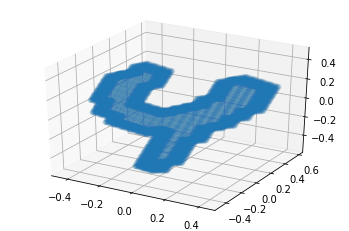

In [ ]:
show_3Dimage(test_points, 50001)

In [ ]:
z = eig_3d_to_2d(test_points['50001'][:])

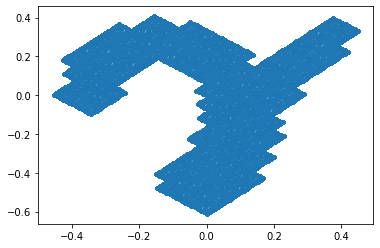

In [ ]:
plt.plot(z[:, 0], z[:, 1], '.')

In [ ]:
img = points2image(z, x_y=[28, 28])

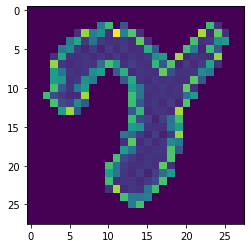

In [ ]:
plt.imshow(img / 255)

- 예외 case

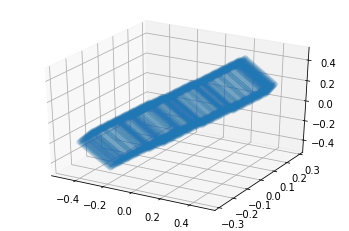

In [ ]:
show_3Dimage(test_points, 50759)

In [ ]:
z = eig_3d_to_2d(test_points['50759'][:])

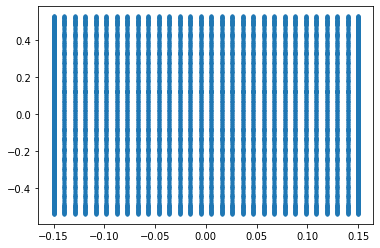

In [ ]:
plt.plot(z[:, 0], z[:, 1], '.')

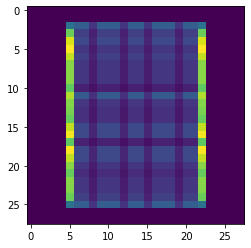

In [ ]:
img = points2image(z, x_y=[28, 28])
plt.imshow(img / 255)

In [ ]:
img[:, 22] - img[:, 5]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

`-` 이런 경우 특이값 분해를 이용

In [ ]:
z = svd_3d_to_2d(test_points['50759'][:])

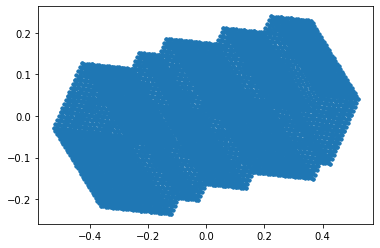

In [ ]:
plt.plot(z[:, 0], z[:, 1], '.')

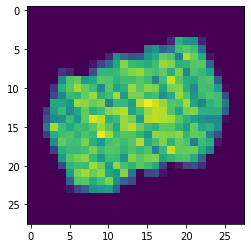

In [ ]:
img = points2image(z, x_y=[28, 28])
plt.imshow(img / 255)

- 3D points $\to$ 2D points $\to$ 2D image

In [ ]:
def get_2d_images(_3d_points_array, id_df, x_y=[28, 28]):   
    all_images = []
    for i in tqdm(id_df.values):
        just_projection = True
        _3d_points = _3d_points_array[str(i)][:]
        _2d_points = project_point2plane(_3d_points)

        if _2d_points is None:
            _2d_points = eig_3d_to_2d(_3d_points)
            just_projection = False
        _2d_image = points2image(_2d_points, x_y)
        
        if not just_projection and np.sum((_2d_image[:, 22] - _2d_image[:, 5]) ** 2) <= 28:  ## 고유값 분해로 원본 이미지를 표현하지 못하면 SVD 사용 (test: 대략 4%)
            _2d_points = svd_3d_to_2d(_3d_points)
            _2d_image = points2image(_2d_points, x_y)  

        all_images.append(_2d_image)
    return all_images

`-` 위의 방식대로 수행해도 test 원본 이미지를 식별하지 못하는 경우가 있다

`-` 이런 경우 이미지는 위에서 scaling을 했을 때의 차원 축소를 적용한 이미지와 비슷하게 생겼다 (모델은 아마 1로 예측할 듯)

`-` 이런 경우 특이값 분해를 사용하거나 특이값 분해도 마찬가지라면 단순히 평면 (xy, yz, zx)에 정사영 시키는 것을 고려해야 한다 (근데 어느 평면에?...)

In [ ]:
train_images = get_2d_images(all_points, label_df['ID'])

100%|██████████| 50000/50000 [26:47<00:00, 31.10it/s]


In [ ]:
np.array(train_images).shape

(50000, 28, 28)

In [ ]:
test_images = get_2d_images(test_points, test_df['ID'])

100%|██████████| 40000/40000 [24:25<00:00, 27.30it/s]


In [ ]:
np.array(test_images).shape

(40000, 28, 28)

- 이미지를 벡터로 변환 후 csv파일로 저장

In [ ]:
train_vectors = np.array(train_images).reshape(-1, 28*28)
test_vectors = np.array(test_images).reshape(-1, 28*28)

In [ ]:
train_vectors.shape, test_vectors.shape

((50000, 784), (40000, 784))

In [ ]:
train_data = pd.DataFrame([])
train_data['ID'] = list(range(50000))

test_data = pd.DataFrame([])
test_data['ID'] = list(range(50000, 90000))

In [ ]:
for i in range(28*28):
    train_data[f'X{i}'] = train_vectors[:, i]
    test_data[f'X{i}'] = test_vectors[:, i]

In [ ]:
# train_data.to_csv('./Data/train_array.csv', index=False)
# test_data.to_csv('./Data/test_array.csv', index=False)

## 모델 학습 준비

In [10]:
!pip install albumentations==1.2.1
!pip install adabelief-pytorch
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 509 kB 18.2 MB/s 


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import _LRScheduler
from torch.nn.modules.loss import _WeightedLoss
from torch.optim import Optimizer
from torch.nn import Module
 
import albumentations as A
from albumentations import Compose
from albumentations.pytorch import ToTensorV2

import timm
from adabelief_pytorch import AdaBelief

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'현재 device는 {device}입니다')

현재 device는 cuda입니다


In [13]:
## 정확도 계산
def accuracy(true: npt.NDArray[np.int_], pred: npt.NDArray[np.int_]) -> float:
    return np.sum(true == pred) / len(true)

In [14]:
def seed_everything(seed: int = 22) -> None:
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [15]:
def clear_gpu() -> None:
    gc.collect()
    torch.cuda.empty_cache()

- 학습 이미지

`-` 3d point 데이터를 보면 숫자마다 점의 개수가 다른데 이를 cover 해주기 위해 이미지마다 픽셀의 최댓값을 1로 맞춰주어 점의 개수의 차이를 없애주겠다

`-` 위와 같이 하면 숫자 이미지간의 점의 개수는 동일하며 어떤 영역에 점이 더 많이 분포하는지가 차이점이다

In [16]:
def change_max_pixel_value(image, new_max_pixel_value=1.0):
    max_pixel_value = np.max(image)
    if max_pixel_value > new_max_pixel_value:
        image *= (new_max_pixel_value / max_pixel_value)
    return image

In [17]:
train_data = pd.read_csv('./Data/train_array.csv').drop('ID', axis=1)
test_data = pd.read_csv('./Data/test_array.csv').drop('ID', axis=1)

- 이미지 픽셀의 최댓값을 1로 변경

In [18]:
for i in tqdm(range(50000)):
    train_data.loc[i, :] = change_max_pixel_value(train_data.loc[i, :])

  0%|          | 0/50000 [00:00<?, ?it/s]

In [19]:
for i in tqdm(range(40000)):
    test_data.loc[i, :] = change_max_pixel_value(test_data.loc[i, :])

  0%|          | 0/40000 [00:00<?, ?it/s]

- 이미지의 채널을 3차원으로 변경

In [20]:
train_images = train_data.to_numpy().reshape(-1, 28, 28, 1)
test_images = test_data.to_numpy().reshape(-1, 28, 28, 1)

In [21]:
train_images = np.concatenate([train_images, train_images, train_images], axis=-1).astype(np.float32)
test_images = np.concatenate([test_images, test_images, test_images], axis=-1).astype(np.float32)

In [22]:
train_images.shape, test_images.shape

((50000, 28, 28, 3), (40000, 28, 28, 3))

- 2D 이미지 시각화

In [ ]:
def show_random_images(
        images: npt.NDArray,
        labels: npt.NDArray[np.int_], 
        label_condition: Optional[int] = None,
        nrows: int = 4, 
        ncols: int = 4
    ) -> None:
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*2, nrows*2))
    if label_condition is not None:
        images = images[labels == label_condition].copy()
        labels = labels[labels == label_condition].copy() 
    idx_list = list(map(int, np.random.uniform(size=nrows*ncols) * images.shape[0]))

    for idx, ax in zip(idx_list, axs.flatten()):
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel(labels[idx])
        ax.imshow(images[idx])       
    fig.tight_layout()

- 숫자 6 이미지

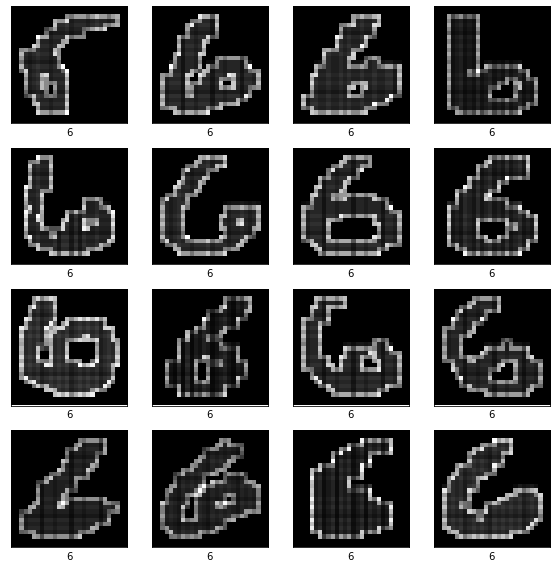

In [ ]:
show_random_images(train_images, target, 6)

- 숫자 9 이미지

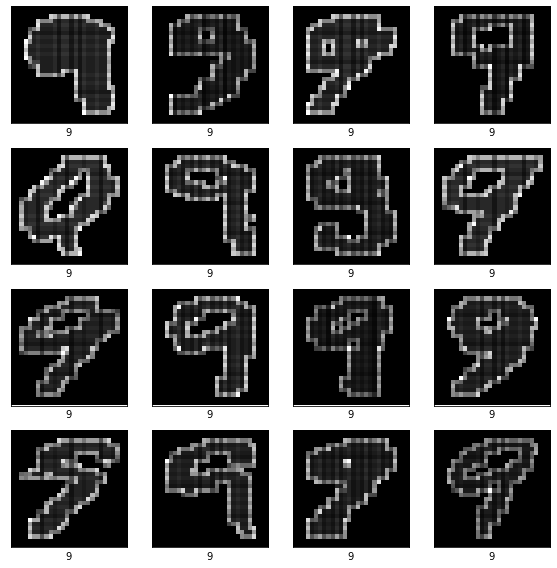

In [ ]:
show_random_images(train_images, target, 9)

- 숫자 2와 5

- 숫자 2 이미지

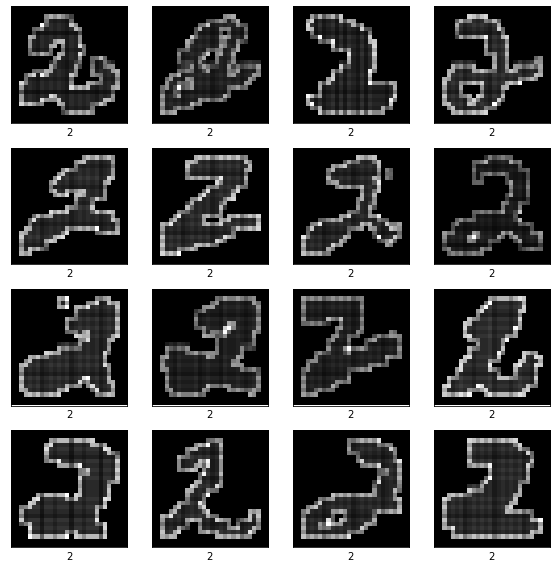

In [ ]:
show_random_images(train_images, target, 2)

- 숫자 5 이미지

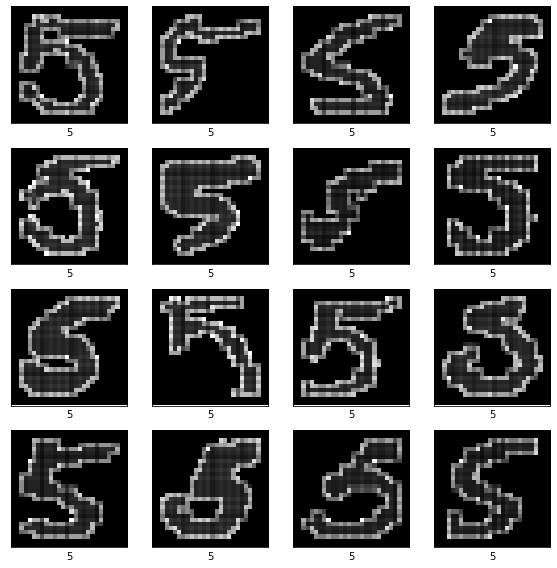

In [ ]:
show_random_images(train_images, target, 5)

- Test 이미지

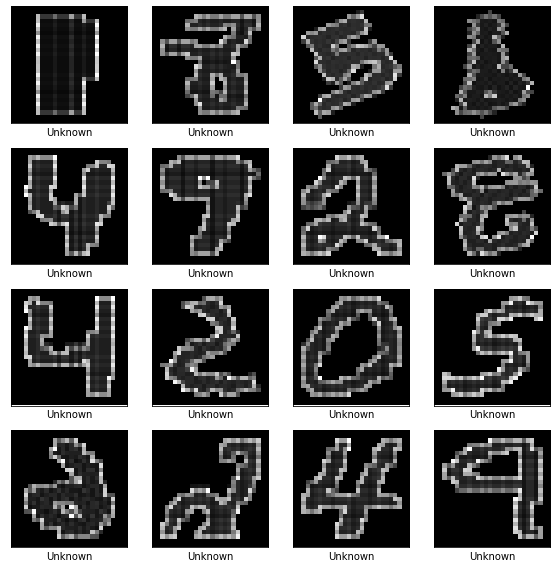

In [ ]:
show_random_images(test_images, ['Unknown'] * 50000)

- 데이터 셋과 데이터 로더

In [23]:
class CustomDataset(Dataset):
    def __init__(
        self,
        images: Sequence[npt.NDArray], 
        labels: Optional[Sequence[int]] = None,
        transforms: Optional[Callable[[Compose], Dict[str, Tensor]]] = None
    ) -> None:
        self.images = images
        self.labels = labels
        self.transforms = transforms
    
    def __getitem__(self, idx: int) -> Union[Tuple[Tensor, int], Tensor]:
        image = self.images[idx]    
        if self.transforms is not None:
            image = self.transforms(image=image)['image']  ## albumentations 사용
        image = torch.tensor(image, dtype=torch.float32)

        if self.labels is not None:
            label = torch.tensor(self.labels[idx], dtype=torch.int64)
            return image, label
        return image  ## test는 라벨이 없다
    
    def __len__(self) -> int:
        return len(self.images)  

In [24]:
def get_dataloader(
        X: Sequence[npt.NDArray], 
        y: Optional[Sequence[int]] = None, 
        transforms: Optional[Callable[[Compose], Dict[str, Tensor]]] = None, 
        shuffle_dataloader: bool = True
    ) -> DataLoader:
    dataset = CustomDataset(X, y, transforms)    
    dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=shuffle_dataloader)
    return dataloader

- 데이터 변환

`-` https://github.com/albumentations-team/albumentations/blob/master/albumentations/augmentations/transforms.py

`-` 위의 링크를 통해 변환함수들의 구조를 확인하자

In [25]:
t = A.Resize(IMAGE_H, IMAGE_W)
x = []
for i in tqdm(range(5000)):  ## 메모리 문제로 5000개만 사용
    x.append(t(image=train_images[i])['image'])
x = np.array(x, dtype=np.float32)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [26]:
RGB_MEAN = [np.mean((x[..., i])) for i in range(3)] 
RGB_STD = [np.std(x[..., i]) for i in range(3)]  

In [27]:
del x

In [62]:
## 데이터 변환 방식을 정의 (Agumentation)
def get_transforms(phase: str) -> Compose:
    if phase == 'train':
        transforms = A.Compose([
            A.Resize(IMAGE_H, IMAGE_W),
            A.HorizontalFlip(p=0.5), 
            A.VerticalFlip(p=0.5),  
            A.Rotate(limit=90, border_mode=cv2.BORDER_CONSTANT, p=1),  ## 무작위로 -limit~limit 각도 회전
            A.RandomGamma(gamma_limit=(80, 120), p=0.5),  ## X -> (X ** gamma_list[0] ~ X ** gamma_list[1])
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.3),  ## 밝기와 대조 조절
            A.ElasticTransform(alpha=0.2, sigma=0, alpha_affine=0, p=0.5),  ## 이미지 흩뿌림
            A.GaussNoise(var_limit=(0.0, 0.01), p=0.3),  ## X -> X + gauss -> 최댓값을 1로 변환하므로 걱정 no
            A.Normalize(mean=RGB_MEAN, std=RGB_STD, max_pixel_value=1.0), 
            ToTensorV2() ## (H X W X C) 차원의 numpy array를 (C X H X W) 차원의 torch tensor로 변환  
        ])
    elif phase == 'valid':
        transforms = A.Compose([
            A.Resize(IMAGE_H, IMAGE_W),
            A.Normalize(mean=RGB_MEAN, std=RGB_STD, max_pixel_value=1.0), 
            ToTensorV2()  
        ])
    elif phase == 'test':
        transforms = A.Compose([
            A.Resize(IMAGE_H, IMAGE_W),
            A.ElasticTransform(alpha=0.2, sigma=0, alpha_affine=0, p=1),   
            A.Normalize(mean=RGB_MEAN, std=RGB_STD, max_pixel_value=1.0), 
            ToTensorV2()   
       ])
        
    return transforms ## 데이터 변환 방식을 반환

- 조기 중단

In [29]:
## Copyright (c) 2018 Bjarte Mehus Sunde
## 코드 참고: https://github.com/Bjarten/early-stopping-pytorch/blob/master/pytorchtools.py
class EarlyStopping:
    """주어진 patience 횟수 이후로 validation score가 개선되지 않으면 학습을 조기 중단"""
    mode_dict = {'min':-1, 'max':1}
    score_metrics = [
                      'accuracy',
                    ]

    def __init__(
        self, 
        patience: int = 7, 
        monitored_quantity: str = 'loss', 
        mode: str = 'min', 
        min_delta: float = 0.0, 
        path: str = './weight', 
        model_name: str = '', 
        current_fold: int = 1
    ) -> None:
        """
        Args:
            patience (int): score가 개선될 때까지 기다리는 에폭
                            Default: 7
                          
            monitored_quantity (str): 값의 변화를 모니터링할 수치(score)
                            Default: 'loss'

            mode (str): score를 개선시킬 방식
                            Default: 'min'

            min_delta (float): 개선되었다고 인정되는 score의 최소 변화
                            Default: 0.0

            path (str): checkpoint 공통 저장 경로
                            Default: './weight'

            model_name (str): 학습시킬 모델의 이름
                            Default: ''

            current_fold (int): 현재 학습을 진행하는 fold의 순서
                            Default: 1
        """
        self.patience = patience
        self.counter = 0
        self.mode = mode
        self.direction = self.mode_dict[mode]
        self.monitored_quantity = monitored_quantity
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None  ## 평가지표 (i.g. accuracy)
        self.early_stop = False
        self.min_delta = min_delta
        self.path = path
        self.model_name = model_name
        self.current_fold = current_fold

    def __call__(
        self, 
        model: Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        ## score는 클수록 좋다
        if self.monitored_quantity == 'loss':
            score = valid_loss * self.direction
        elif self.monitored_quantity in self.score_metrics:
            score = valid_metric_score * self.direcion
        else:
            score = None

        ## score가 개선되었는지 확인
        if score <= self.best_score + self.min_delta: 
            self.counter += 1 
            if self.counter > self.patience:  ## 만약 score가 개선되지 않은 에폭이 patience 횟수보다 크다면 조기 중단
                self.early_stop = True
        else: 
            self.best_score = score 
            self.save_checkpoint(model, valid_loss, valid_metric_score) 
            self.counter = 0  ## score가 개선되었으므로 0으로 변경

    def save_checkpoint(
        self, 
        model: Module, 
        valid_loss: float, 
        valid_metric_score: Optional[float] = None
    ) -> None:
        """validation score가 개선되면 모델을 저장"""
        torch.save(model.state_dict(), self.path + f'/{self.model_name}_best_{self.current_fold}.pt') 
        self.valid_loss = valid_loss  ## 모델이 더 좋게 갱신되었으므로 이때의 valid loss를 기준치로 변경
        self.valid_metric_score = valid_metric_score  ## 이때의 valid metric score도 변경해준다

    def check_early_stop(self) -> bool:
        return self.early_stop

    def set_fold(self, current_fold: int) -> None:
        self.current_fold = current_fold

    def reset_score(self) -> None:
        """다음 fold 학습을 위해 score 관련 파라미터를 초기화"""
        self.counter = 0
        self.best_score = -np.Inf
        self.valid_loss = np.Inf
        self.valid_metric_score = None
        self.early_stop = False

## 모델 K겹 교차검증

In [30]:
from sklearn.model_selection import StratifiedKFold

- Kfold와 손실 함수

In [31]:
skfold = StratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=SEED)
loss_fn = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)

- early stopping

In [32]:
early_stopping = EarlyStopping(patience=7,
                               path=SAVE_PATH,
                               model_name=MODEL_NAME,
                               current_fold=1)  ## patience 횟수 에폭 후에도 검증 손실이 작아지지 않으면 조기 중단

In [33]:
def train(
        model: Module,
        dataloader: DataLoader, 
        optimizer: Optimizer, 
        loss_fn: _WeightedLoss, 
        scheduler: Optional[_LRScheduler] = None
    ) -> Tuple[Module, float]:
    """dataloader의 데이터로 모델을 학습시킨 후 학습된 모델과 평균 배치 훈련 오차를 반환"""  
    train_loss = 0.0  ## mini-batch 평균 훈련 오차 
    model = model.to(device)
    model.train()

    for X, y in tqdm(dataloader):  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
        X, y = X.to(device), y.to(device)
        y_hat = model(X)
        loss = loss_fn(y_hat, y)  
        optimizer.zero_grad()  ## 그래디언트 초기화
        loss.backward()   ## 미분
        optimizer.step()  ## 업데이트
        train_loss += (loss.item() / len(dataloader)) 
  
    ## 에폭마다 학습률 조절
    if scheduler is not None:
        scheduler.step()

    return model, train_loss

In [34]:
def evaluate(
        model: Module, 
        dataloader: DataLoader, 
        loss_fn: _WeightedLoss
    ) -> Tuple[float, float]:
    """dataloader의 데이터를 모델이 평가한 후 평균 배치 검증 오차와 정확도를 반환"""
    valid_acc, valid_loss = 0.0, 0.0  ## mini-batch 평균 검증 오차와 정확도 
    model = model.to(device)
    model.eval()  

    with torch.no_grad():  ## 역전파를 계산할 필요가 없으니까
        for X, y in dataloader:  ## 미니 배치 단위로 꺼내온다, X는 미니 배치, y는 레이블
            X, y = X.to(device), y.to(device)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)  
            acc = accuracy(y.cpu().numpy(), y_hat.cpu().numpy().argmax(-1))    
            valid_loss += loss.item() / len(dataloader)
            valid_acc += (acc * len(y) / len(dataloader.dataset))  ## 각 배치마다 정확도(정답 개수 / 전체 개수)

    return valid_loss, valid_acc

In [37]:
def kfold_cross_validate(
        model: Module, 
        X: Sequence[npt.NDArray], 
        y: Sequence[int], 
        skfold: StratifiedKFold, 
        loss_fn: _WeightedLoss, 
        early_stopping: EarlyStopping
    ) -> Tuple[Module, List[List[float]], List[List[float]]]:
    """K겹 교차검증을 통해 모델의 성능을 평가하고 학습된 모델과 폴드별 훈련 손실, 폴드별 검증 손실을 반환"""
    seed_everything(SEED)  ## 정확한 재현을 위함
    num_folds = skfold.n_splits  ## 폴드의 개수
    fold_valid_loss = []  ## 폴드별 가장 작은 검증 손실
    fold_valid_acc = []  ## 폴드별 가장 작은 검증 손실을 가질 때의 정확도
    fold_train_losses_per_epoch = [[] for _ in range(num_folds)]  ## 폴드별 1 에폭에 따른 훈련 배치 손실
    fold_valid_losses_per_epoch = [[] for _ in range(num_folds)]  ## 폴드별 1 에폭에 따른 검증 배치 손실

    for fold, (train_idx, valid_idx) in enumerate(skfold.split(X, y)):
        print(f'[{fold + 1} / {num_folds}] Fold Training......')
        if fold != 2:
            continue

        ## 메모리 절약
        clear_gpu()
        
        ## 훈련 데이터와 검증 데이터로 분할
        X_train, X_valid = X[train_idx], X[valid_idx] 
        y_train, y_valid = y[train_idx], y[valid_idx]

        ## Dataloader
        train_dataloader = get_dataloader(X_train, y_train, get_transforms('train'))
        valid_dataloader = get_dataloader(X_valid, y_valid, get_transforms('valid'))

        ## 딥러닝 모델의 기본 가중치 불러오기
        model.load_state_dict(torch.load(MODEL_DEFAULT_WEIGHT_PATH, map_location=device))
        # model.load_state_dict(torch.load('./weight/efficientnet_b1_best_2.pt', map_location=device)) 

        ## optimizer, scheduler (수동으로 선택)
        optimizer = AdaBelief(model.parameters(),
                      lr=LEARNING_RATE,  ## LEARNING_RATE
                      eps=1e-8,
                      weight_decay=1e-2,
                      betas=(0.9, 0.999),
                      weight_decouple=True,
                      rectify=False,
                      print_change_log=False)
        
        scheduler = None

        ## early stop, 다음 폴드 학습을 위해 score 관련 파라미터 초기화
        early_stopping.reset_score()
        early_stopping.set_fold(fold + 1)  
        
        ## 폴드마다 모델 학습
        for epoch in tqdm(range(1, NUM_EPOCHS + 1)): ## (배치사이즈 X 에폭) 만큼 훈련시킴           
            model, train_loss = train(model, train_dataloader, optimizer, loss_fn, scheduler)  ## 모델 학습
            valid_loss, valid_acc = evaluate(model, valid_dataloader, loss_fn)  ## 모델 평가
            fold_train_losses_per_epoch[fold].append(train_loss) 
            fold_valid_losses_per_epoch[fold].append(valid_loss)  

            print_score_condition = (epoch == 1 or epoch % 1 == 0 or epoch == NUM_EPOCHS)  ## 10의 배수값을 가지는 에폭마다 score 출력
            score_information = f'[Epoch: {epoch:>2}]  train loss = {train_loss:.5f}  valid loss = {valid_loss:.5f}  valid acc = {valid_acc:.5f}'

            ## 평균 배치 훈련 오차와 검증 오차 출력
            if print_score_condition:  
                print(score_information)  
                
            ## 에폭마다 early stopping 실행
            early_stopping(model, valid_loss, valid_acc)  ## __call__ function
            if early_stopping.check_early_stop(): 
                if not print_score_condition:  ## 이미 출력한 에폭에 대해 중복으로 출력하지 않기 위함
                    print(score_information) 
                print('Early Stopping!')
                break 

        fold_valid_loss.append(early_stopping.valid_loss)  ## 폴드별 가장 작은 검증 손실
        fold_valid_acc.append(early_stopping.valid_metric_score)  ## 폴드별 가장 작은 검증 손실일 때의 정확도
         
        ## 폴드별 학습 및 검증 종료시 가장 작은 검증 손실과 이때의 정확도를 출력
        print(f'{fold + 1} Fold -> Best Valid Loss: {early_stopping.valid_loss:.5f} Valid Accuracy: {early_stopping.valid_metric_score:.5f}', end='\n\n')
        
    ## 폴드별 가장 손실이 작은 모델의 평균 검증 손실과 이때의 평균 정확도를 출력
    print(f'{num_folds} Fold Mean Valid Best Loss: {np.mean(fold_valid_loss):.5f}')
    print(f'{num_folds} Fold Mean Valid Accuracy: {np.mean(fold_valid_acc):.5f}')

    return model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch

- 모델 선언 및 가중치 저장

In [36]:
model = timm.create_model(MODEL_NAME, pretrained=True, num_classes=NUM_CLASSES)
torch.save(model.state_dict(), MODEL_DEFAULT_WEIGHT_PATH)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth


- 모델 K겹 교차검증

20:45 시작, 이미 4시간 사용,1234567891011

이미지 크기 112*112 기준 에폭 하나당 5분 정도 걸림

2234

In [38]:
model, fold_train_losses_per_epoch, fold_valid_losses_per_epoch = kfold_cross_validate(model, train_images, target, skfold, loss_fn, early_stopping)

[1 / 5] Fold Training......
[2 / 5] Fold Training......
Weight decoupling enabled in AdaBelief


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  1]  train loss = 0.38641  valid loss = 0.36493  valid acc = 0.97490


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  2]  train loss = 0.37653  valid loss = 0.36371  valid acc = 0.97550


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  3]  train loss = 0.36684  valid loss = 0.36957  valid acc = 0.97100


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  4]  train loss = 0.35825  valid loss = 0.35953  valid acc = 0.97610


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  5]  train loss = 0.35289  valid loss = 0.36177  valid acc = 0.97320


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  6]  train loss = 0.34684  valid loss = 0.35753  valid acc = 0.97650


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  7]  train loss = 0.34510  valid loss = 0.35765  valid acc = 0.97470


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  8]  train loss = 0.33821  valid loss = 0.34839  valid acc = 0.98020


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch:  9]  train loss = 0.33545  valid loss = 0.36108  valid acc = 0.97540


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 10]  train loss = 0.33109  valid loss = 0.35060  valid acc = 0.97840


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 11]  train loss = 0.33025  valid loss = 0.34897  valid acc = 0.97900


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 12]  train loss = 0.35228  valid loss = 0.34833  valid acc = 0.97920


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 13]  train loss = 0.34883  valid loss = 0.35162  valid acc = 0.97930


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 14]  train loss = 0.34669  valid loss = 0.35418  valid acc = 0.97650


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 15]  train loss = 0.34501  valid loss = 0.34656  valid acc = 0.97980


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 16]  train loss = 0.34185  valid loss = 0.34427  valid acc = 0.98060


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 17]  train loss = 0.33762  valid loss = 0.34603  valid acc = 0.97800


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 18]  train loss = 0.33521  valid loss = 0.34267  valid acc = 0.98000


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 19]  train loss = 0.33310  valid loss = 0.33557  valid acc = 0.98310


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 20]  train loss = 0.33289  valid loss = 0.34475  valid acc = 0.98060


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 21]  train loss = 0.33023  valid loss = 0.34031  valid acc = 0.98150


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 22]  train loss = 0.32800  valid loss = 0.33884  valid acc = 0.98170


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 23]  train loss = 0.32735  valid loss = 0.33695  valid acc = 0.98300


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 24]  train loss = 0.32701  valid loss = 0.33976  valid acc = 0.98120


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 25]  train loss = 0.32292  valid loss = 0.33987  valid acc = 0.98070


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 26]  train loss = 0.32319  valid loss = 0.34515  valid acc = 0.97930


  0%|          | 0/2500 [00:00<?, ?it/s]

[Epoch: 27]  train loss = 0.32198  valid loss = 0.34199  valid acc = 0.98120
Early Stopping!
2 Fold -> Best Valid Loss: 0.33557 Valid Accuracy: 0.98310

[3 / 5] Fold Training......
[4 / 5] Fold Training......
[5 / 5] Fold Training......
5 Fold Mean Valid Best Loss: 0.33557
5 Fold Mean Valid Accuracy: 0.98310


- train loss와 valid loss의 변화를 시각화

In [ ]:
def show_loss_plot(
        fold_train_losses: List[List[float]],
        fold_valid_losses: List[List[float]]
    ) -> None:
    """폴드별로 에폭에 따른 모델의 훈련 손실과 검증 손실의 변화를 시각화"""
    assert len(fold_train_losses) == len(fold_valid_losses)
    num_folds = len(fold_train_losses)
    ncols = 3
    nrows = 1 + (num_folds - 1)//ncols
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols*4, nrows*4)) 

    ## 폴드마다 에폭에 따른 훈련 손실과 검증 손실의 변화를 시각화
    for fold, (ax, train_losses, valid_losses) in enumerate(zip(axes.flatten(), fold_train_losses, fold_valid_losses), start=1):
        assert len(train_losses) == len(valid_losses) 
        if fold > num_folds:
            break

        num_epochs = len(train_losses)
        ax.set_title(f'{fold} Fold')
        ax.plot(range(1, num_epochs+1), train_losses, label='Train')
        ax.plot(range(1, num_epochs+1), valid_losses, label='Valid')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.legend()

    fig.suptitle('Train Loss and Valid Loss', x=0.51, y=1.05, fontsize=15)
    fig.tight_layout()

    ## 남는 서브 플랏 제거
    for ax in axes.flatten():
        if not ax.has_data():
            fig.delaxes(ax)

In [ ]:
# show_loss_plot(fold_train_losses_per_epoch, fold_valid_losses_per_epoch)

## Test 예측

In [39]:
!pip install ttach

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import ttach as tta

`-` 3차원 이미지를 2차원 이미지로 축소된 결과물이 일반적으로 알고있는 형태와 다르다 (예컨대 6이 거꾸로 뒤집어 있다)

`-` 왜냐하면 같은 라벨이더라도 3차원 상에서 rotate, flip 되어있는 이미지가 존재하기 때문이다

`-` 즉, 3차원 상에서는 동일한 숫자이미지라도 rotate 또는 flip 되어도 구분이 가능하다 (쉽지는 않다...)

`-` 따라서 이미지의 형태를 보고 라벨을 맞춰야 한다 (예컨대 6은 막대기가, 9는 동그라미가 강조되어있다; 그런데 내가 몇개만 확인한거라 아닐수도 있다)

`-` 이미지를 rotate 또는 flip 하더라도 동일하므로 예측해야할 이미지에 roate와 flip을 적용하여 일반화 성능을 올리겠다

In [52]:
def predict(
        model: Module, 
        dataloader: DataLoader, 
        weight_save_path: str, 
        tta_transforms: Optional[tta.base.Compose] = None,
        return_prob: bool = False
    ) -> Tensor:
    """저장된 모델의 가중치를 불러와서 dataloader의 데이터를 예측하여 반환"""
    model = model.to(device) 
    weight_path_list = glob(weight_save_path + '/*.pt')
    test_probs = np.zeros(shape=(len(dataloader.dataset), NUM_CLASSES))  

    for weight_path in tqdm(weight_path_list):
        if '3' in weight_path:  ## 학습시킨 모델의 가중치만 예측하는데 사용
            continue
        if MODEL_NAME not in weight_path:  ## 학습시킨 모델의 가중치만 예측하는데 사용
            continue
            
        probs = None
        model.load_state_dict(torch.load(weight_path, map_location=device))
        model.eval()

        if tta_transforms is not None:
            tta_model = tta.ClassificationTTAWrapper(model, tta_transforms)
        
        with torch.no_grad(): 
            for X in dataloader:  ## test 데이터는 라벨(y)이 없다
                X = X.to(device) 
                if tta_transforms is not None:
                    y_hat = tta_model(X).cpu().numpy()
                else:
                    y_hat = model(X).cpu().numpy()

                if probs is None:
                    probs = y_hat
                else:
                    probs = np.concatenate([probs, y_hat])

        test_probs += (probs / NUM_FOLDS) 
    test_probs = torch.softmax(torch.tensor(test_probs), dim=1)  ## 각 컬럼별 확률
    _, test_preds = torch.max(test_probs, dim=1)  ## 최댓값과 인덱스

    if return_prob:
        return test_probs  ## 각 컬럼별 확률
    return test_preds  ## 라벨

In [63]:
test_dataloader = get_dataloader(X=test_images, y=None, transforms=get_transforms('test'), shuffle_dataloader=False)

In [64]:
tta_transforms = tta.Compose(
    [
        #tta.Rotate90([0, 90, 180, 270]),
        tta.HorizontalFlip(),
        tta.VerticalFlip(),
    ]
)

In [65]:
preds = predict(model, test_dataloader, SAVE_PATH, tta_transforms, return_prob=False)

  0%|          | 0/5 [00:00<?, ?it/s]

In [66]:
test_df['label'] = preds
test_df.head()

,ID,label
0,50000,7
1,50001,2
2,50002,2
3,50003,4
4,50004,9


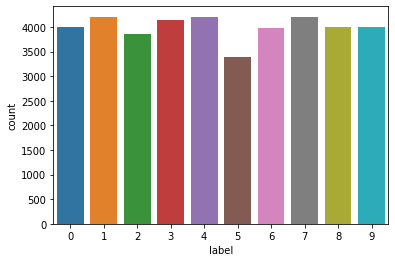

In [67]:
sns.countplot(data=test_df, x='label')

In [68]:
test_df.to_csv(f'./Data/submission-{MODEL_NAME}-16.csv', index=False)